In [1]:
import xarray
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from utils.plotting import prediction_error_plot


In [2]:
stations = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/IEA_PVPS_europe.zarr')
sarah = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr')

In [3]:
print(stations.station_name.values)

['CAB' 'CAR' 'CEN' 'MIL' 'NOR' 'PAL' 'PAY' 'TAB' 'TOR' 'VIS']


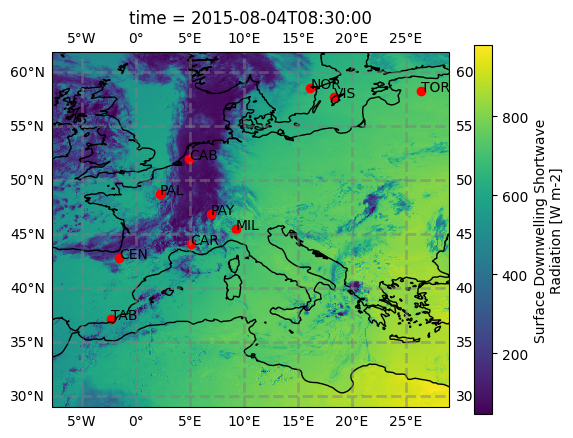

In [4]:
proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = stations.latitude.values
lon = stations.longitude.values
name = stations.station_name.values
axis.scatter(x=lon, y=lat, c='r')
for i, txt in enumerate(name):
    axis.annotate(txt, (lon[i], lat[i]))

sarah.SIS.isel(time = 10310).plot.imshow(ax=axis, transform = proj)

In [ ]:
def sarah_predictions(station, time_window=12):
    print(station, ' Start')
    lat = stations.sel(station_name=station).latitude.data
    lon = stations.sel(station_name=station).longitude.values
    ilat = (np.abs(sarah.lat - lat)).argmin().values
    ilon = (np.abs(sarah.lon - lon)).argmin().values
    rolling = stations.sel(station_name=station) \
            .rolling(time=time_window,center=False) \
            .mean().dropna(dim='time')
    # rolling average of X minutes (seviri takes X min to create an image, RSS=5min, normal full disk 12min)
    # mean becomes a nan if a single nan value is encountered in GHI

    # mean index is the right most index -> convert to left most index to relate to hrseviri
    rolling['time'] = rolling['time'] - np.timedelta64(time_window, 'm')

    print('sarah samples',len(sarah.time))
    print('station samples', len(rolling.time))
    timenotnan = set(rolling.time.values).intersection(set(sarah.time.values))
    timenotnan = np.sort(np.array(list(timenotnan)))
    print('collocated time-averaged samples:', len(timenotnan))
    
    sarah_timeseries = sarah.sel(time=timenotnan).isel(lat=ilat, lon=ilon)
    CAB_timeseries = rolling.sel(time=timenotnan)
    y = CAB_timeseries.GHI.values
    y_hat = sarah_timeseries.SIS.values
    combined = xarray.merge([sarah_timeseries, CAB_timeseries])
    return y, y_hat, combined

In [ ]:
predictions_stations = {nm: sarah_predictions(nm) for nm in stations.station_name.values}
predictions_stations = {nm: {'y': p[0], 'y_hat':p[1], 'combined': p[2]} for nm, p in predictions_stations.items()} 


CAB: 	 mean error: -2 std error: 77
CAR: 	 mean error: 6 std error: 74
CEN: 	 mean error: -1 std error: 89
MIL: 	 mean error: 14 std error: 74
NOR: 	 mean error: -6 std error: 75
PAL: 	 mean error: 4 std error: 82
PAY: 	 mean error: -18 std error: 80
TAB: 	 mean error: 2 std error: 77
TOR: 	 mean error: -11 std error: 91
VIS: 	 mean error: -12 std error: 100


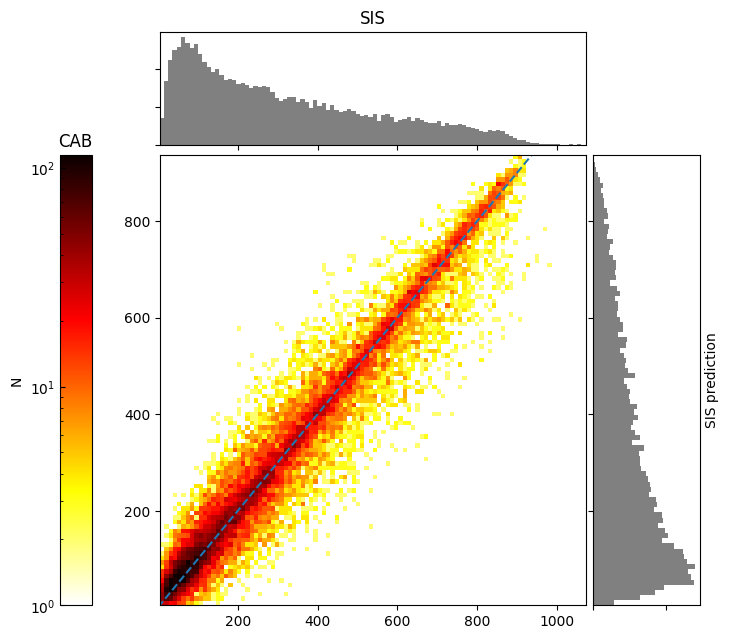

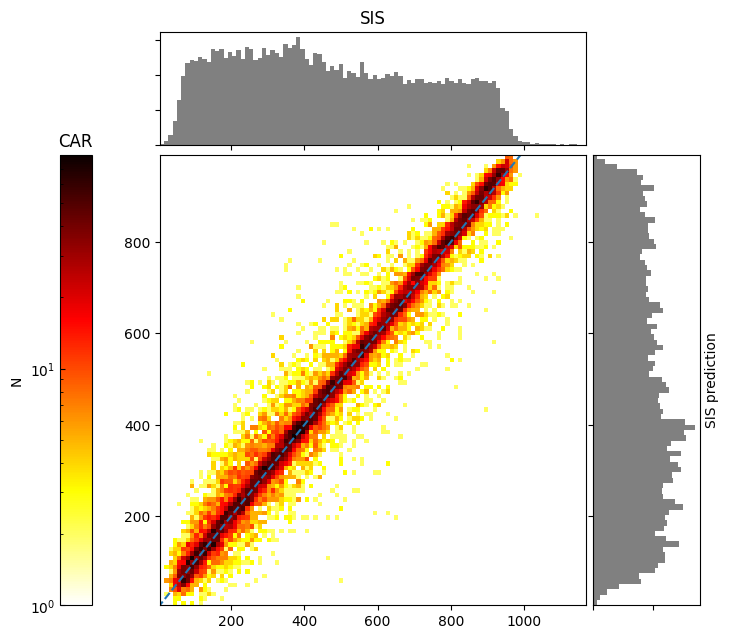

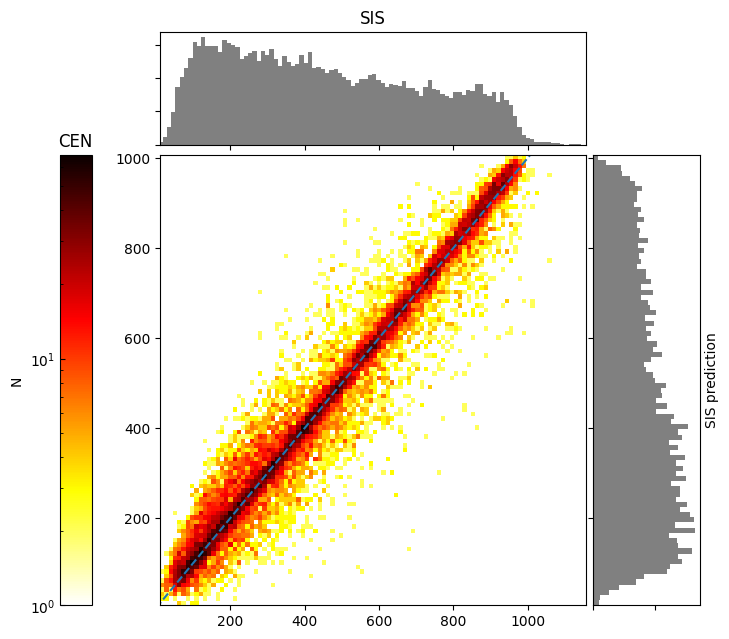

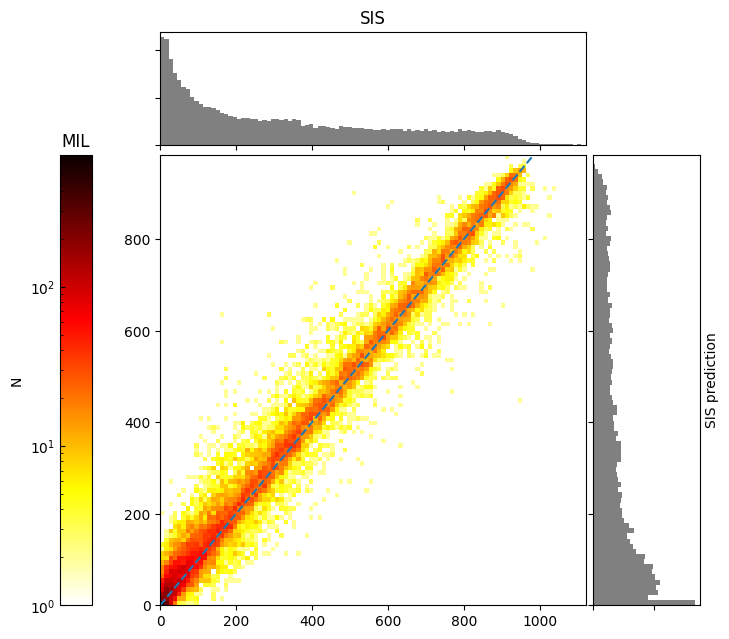

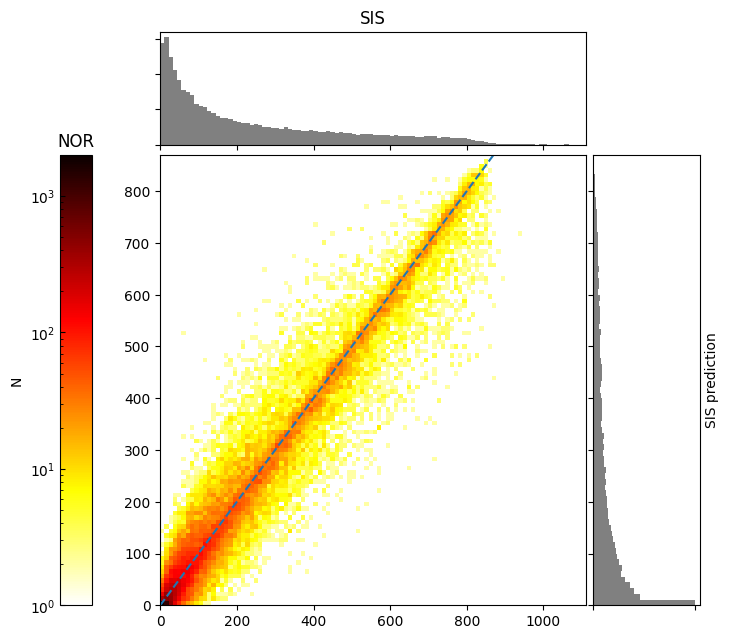

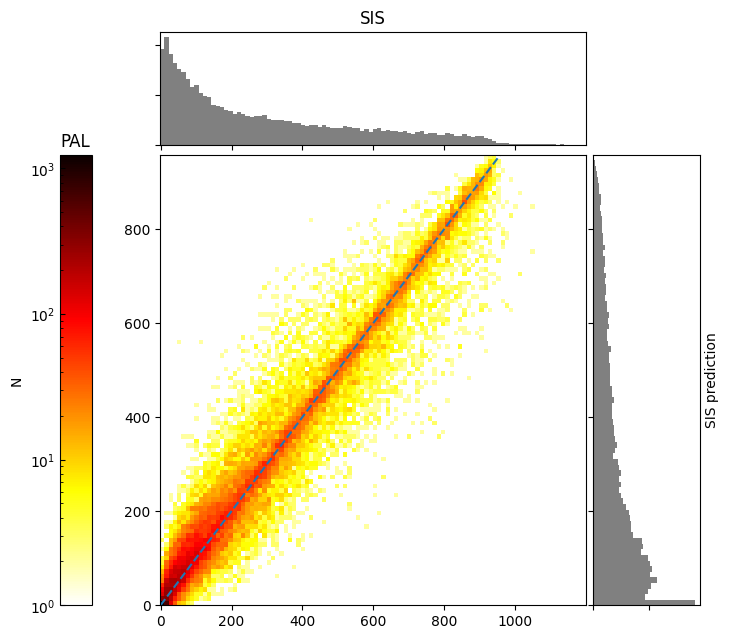

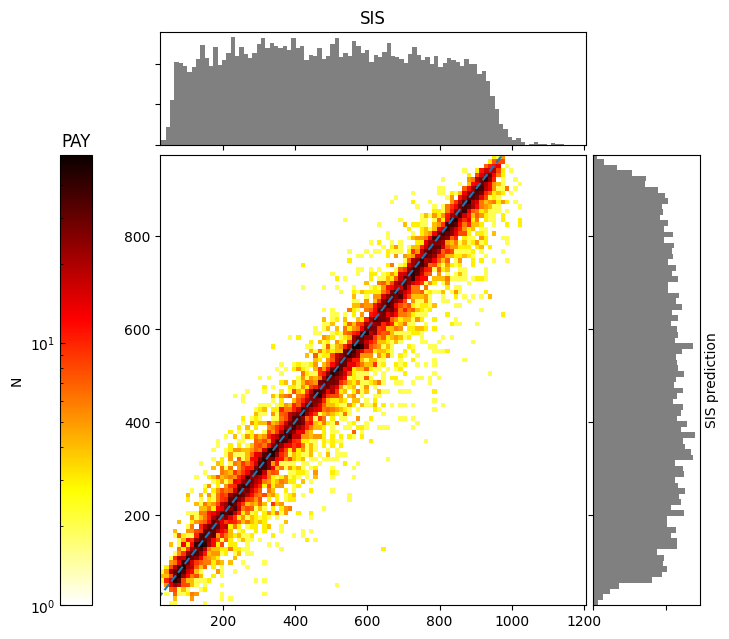

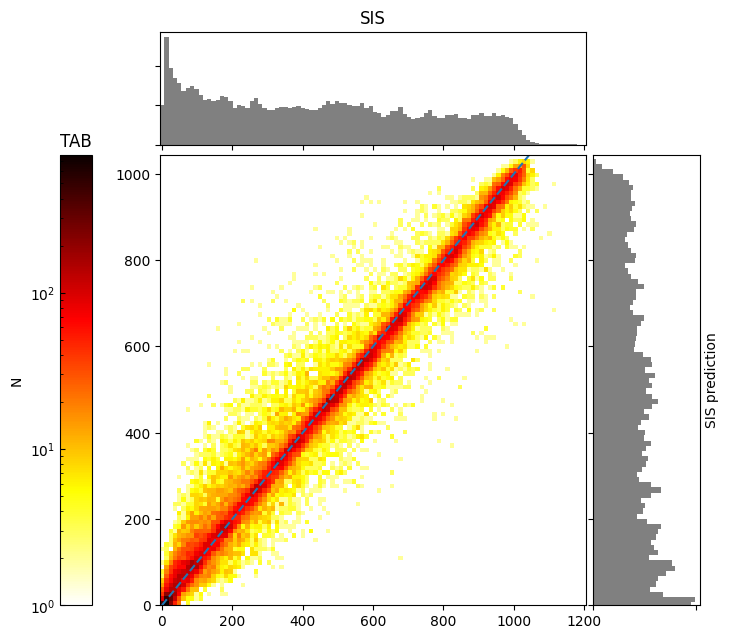

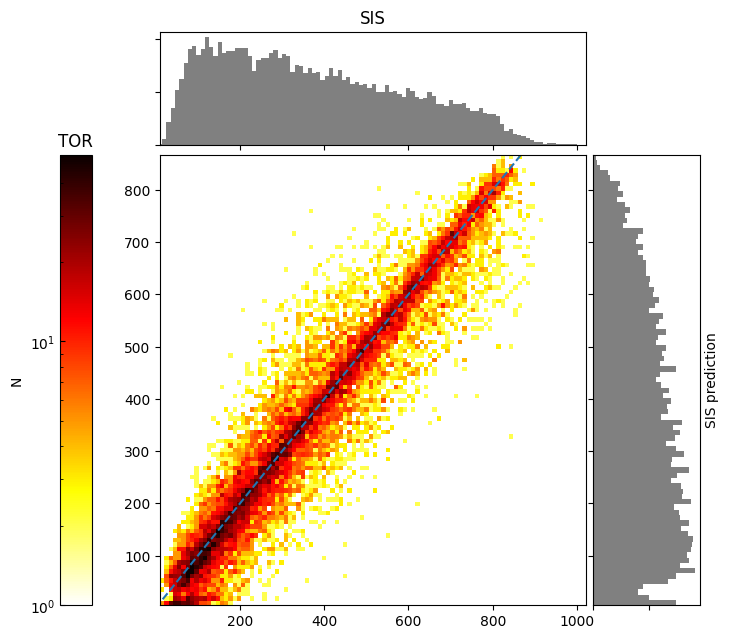

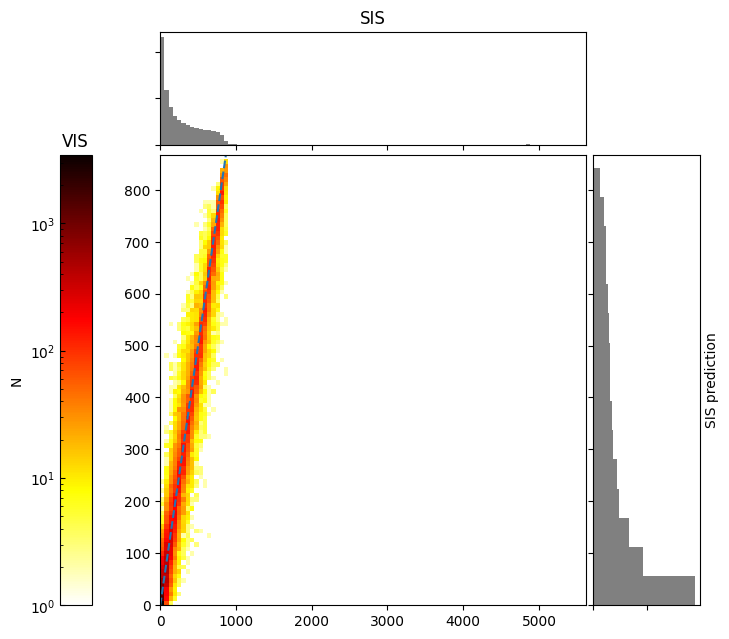

In [28]:
for key, val in predictions.items():
    y_hat = val['y_hat']
    y = val['y']
    error = y_hat - y
    mean = np.mean(error).item()
    std = np.std(error).item()
    print(f"{key}: \t mean error: {round(mean)} \t std error: {round(std)}")
    prediction_error_plot(y, y_hat, title=key)

